# Задание 1
Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:

- Сгенерировать настоящие данные  
- Изменить архитектуру дискриминатора и генератора  
- Наличие графиков обязательно  

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
x = np.linspace(-15, 15, 1001)
if 0 in x:
    print("Есть 0")

Есть 0


In [3]:
def func_y(x):    
    if 0 in x:
        x[x == 0] = 0.00001
    return np.sin(x)/x - x/10

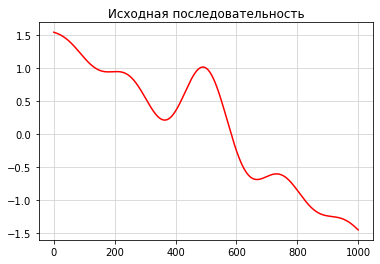

In [4]:
y = func_y(x)
plt.plot(y, 'r')
plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

In [5]:
class Inc_Dataset(Dataset):
    def __init__(self, b_border, u_border, point_number):
        x = np.linspace(b_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [6]:
dataset = Inc_Dataset(-15, 15, 1001)

In [15]:
split_train_part = 0.75
batch_size = 16

real_data_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
real_data_loader = DataLoader(real_data_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Генератор

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        # self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.sph = nn.Softplus()

    def forward(self, x):
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc1(x))
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc2(x))
        # x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        # print("X размеры in: %s\n" % (x.shape,))
        return x

# Дискриминатор

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        # self.sfm = nn.Softmax()

    def forward(self, x):
        # print("X размеры d in: %s\n" % (x.shape,))
        x = self.relu(self.fc1(x))
        # print("X размеры fc1 sigm in: %s\n" % (x.shape,))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        x = self.sigm(self.fc4(x))
        return x

# Инициализация

In [10]:
n_epochs = 1000
lr = 0.0001   # 0.0005

b1 = 0.5
b2 = 0.999

sample_interval = 50

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss()

In [12]:
d_loss_history = []
g_loss_history = []

In [13]:
idx = torch.randperm(16)
idx

tensor([ 7,  9,  8,  3, 14,  1, 13, 11,  2, 10,  4, 12,  5, 15,  0,  6])

In [16]:
for epoch in range(1):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([-10.2600,   7.4400,   3.9600,  -9.7800, -14.5800,   8.1900,   1.0500,
          8.0100,   9.3900,   5.1600, -11.6700,  12.5700, -14.5200, -11.0100,
         -9.8700,   2.4300], device='cuda:0')
z: tensor([[-10.2600],
        [ -9.8700],
        [  1.0500],
        [  3.9600],
        [-14.5800],
        [ -9.7800],
        [-11.6700],
        [  8.1900],
        [  7.4400],
        [-11.0100],
        [  9.3900],
        [  8.0100],
        [ 12.5700],
        [  2.4300],
        [  5.1600],
        [-14.5200]], device='cuda:0')
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


[Epoch 498/500] [Batch 44/47] [D loss: 0.599620] [G loss: 0.813197]


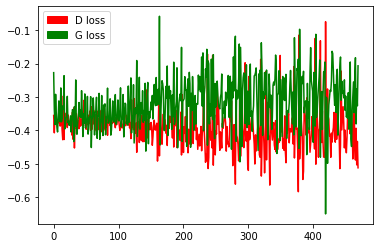

In [17]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(real_data_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [18]:
torch.save(generator.state_dict(), "series_gan.pth")

In [19]:
generator_r = Generator().to(device)
generator_r.load_state_dict(torch.load("series_gan_loss_min.pth"))

<All keys matched successfully>

In [20]:
x =  np.linspace(-15, 15, 50)
xt = torch.from_numpy(x).type(torch.FloatTensor).to(device)
xt.type()

'torch.cuda.FloatTensor'

In [21]:
gen_numbers = generator_r(xt.view(len(x), 1))

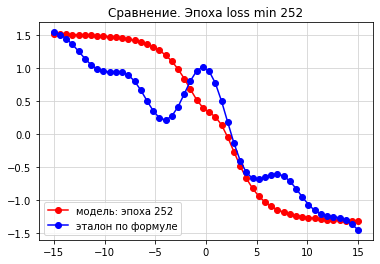

In [22]:
plt.plot(x, gen_numbers.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {ep_loss}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title(f'Сравнение. Эпоха loss min {ep_loss}' )
plt.show()

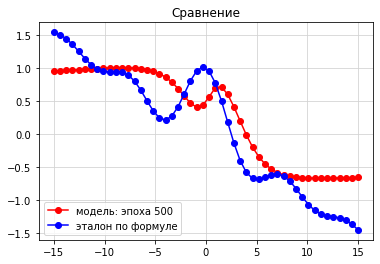

In [23]:
generator_f = Generator().to(device)
generator_f.load_state_dict(torch.load("series_gan.pth"))

gen_numbers_f = generator_f(xt.view(len(x), 1))

plt.plot(x, gen_numbers_f.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {n_epochs}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

# Тестовый dataset

In [24]:
x_test = []
y_test = []

for x, y in test_loader:
    x_test.append(x), y_test.append(y)

In [25]:
xt = torch.FloatTensor(x_test).to(device)
gen_numbers_t = generator_f(xt.view(len(x_test), 1))

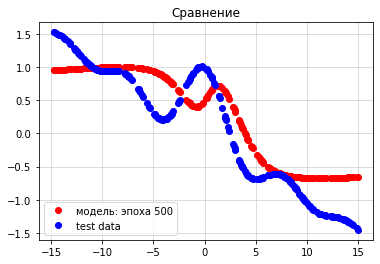

In [26]:
plt.plot(x_test, gen_numbers_t.detach().cpu().numpy(), 'ro', label=f"модель: эпоха {n_epochs}")
plt.plot(x_test, y_test, 'bo', label=f"test data")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()